# PTEN in Endo and GBM

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
gbm = cptac.Gbm()
endo = cptac.Endometrial()

In [3]:
cancer1 = "GBM"
cancer2 = "Endometrial"
gene = 'PTEN'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = gbm.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = gbm.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)


In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for GBM\n")

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

Doing t-test comparisons for GBM



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


No significant comparisons.


In [6]:
wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
0,PTEN_proteomics,0.000032


In [7]:
# endo ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = endo.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)


In [8]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for Endometrial")

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for Endometrial
78 significant comparisons!


In [9]:
wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
7303,PTEN_proteomics,0.018255


In [10]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [11]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "red", "lightblue")
print(interacting_list)
#combined.loc[combined['color'] == 'red']
both_values_df = combined.dropna(axis=0, how='any') # only keep rows with both data points
both_values_df

['MDM2', 'CSNK2A1', 'PDGFRB', 'PIK3R2', 'PIK3C3', 'CSNK2A2', 'SLC9A3R1', 'PIK3R3', 'USP13', 'PIK3CA', 'TP53', 'EGFR', 'PIK3CB', 'PTK2', 'USP7', 'XIAP', 'PTEN', 'PREX2', 'MAST2', 'PIK3CD', 'ROCK1', 'SHC1', 'NEDD4', 'INPP4B', 'PIK3R1', 'AKT1', 'MVP', 'MAGI3']


,Comparison,P_Value_x,P_Value_y,color
0,PTEN,0.000032,0.018255,red
1,CALD1,0.000227,0.831139,lightblue
2,FLNC,0.000240,0.987449,lightblue
3,ERBB2,0.000491,0.000164,lightblue
4,MAPK8IP3,0.000499,0.000446,lightblue
...,...,...,...,...
9792,METTL26,0.997759,0.049312,lightblue
9793,ZNF207,0.998493,0.406304,lightblue
9794,POLB,0.999058,0.050598,lightblue
9795,TIMM21,0.999198,0.182861,lightblue


Visualize all P-values

In [11]:
pathways = pd.read_excel(R"E:\Users\brittany henderson\Documents\Junior BYU\WikiPathwaysData.xlsx")


In [13]:
#combine pval results
combined_2 = wrap_results.merge(wrap_results2, on='Comparison')
combined_df = combined_2.replace(regex=True,to_replace='_proteomics', value='')
combined_df

,Comparison,P_Value_x,P_Value_y
0,PTEN,0.000032,0.018255
1,CALD1,0.000227,0.831139
2,FLNC,0.000240,0.987449
3,ERBB2,0.000491,0.000164
4,MAPK8IP3,0.000499,0.000446
...,...,...,...
9792,METTL26,0.997759,0.049312
9793,ZNF207,0.998493,0.406304
9794,POLB,0.999058,0.050598
9795,TIMM21,0.999198,0.182861


In [14]:
c_path = combined_df.merge(pathways, left_on='Comparison', right_on='Gene')
#c_path = c_path.rename(columns={'P_Value_x':'Gbm P-Values', 'P_Value_y': 'En P-Values',
#               'Focal Adhesion-PI3K-Akt-mTOR-signaling pathway' : 'Focal Adhesion'})
c_path


,Comparison,P_Value_x,P_Value_y,Gene,Target Of Rapamycin (TOR) Signaling,NRF2-ARE regulation,PDGF Pathway,Eukaryotic Transcription Initiation,Interleukin-11 Signaling Pathway,Vitamin D Receptor Pathway,...,Serotonin Transporter Activity,TCA Cycle (aka Krebs or citric acid cycle),Serotonin and anxiety,Sudden Infant Death Syndrome (SIDS) Susceptibility Pathways,Canonical NF-KB pathway,Photodynamic therapy-induced HIF-1 survival signaling,Arrhythmogenic Right Ventricular Cardiomyopathy,Ethanol metabolism resulting in production of ROS by CYP2E1,Interactions between immune cells and microRNAs in tumor microenvironment,Metabolism of Tetrahydrocannabinol (THC)
0,PTEN,0.000032,0.018255,PTEN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,CALD1,0.000227,0.831139,CALD1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,FLNC,0.000240,0.987449,FLNC,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,ERBB2,0.000491,0.000164,ERBB2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,MAPK8IP3,0.000499,0.000446,MAPK8IP3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,VWF,0.982674,0.122860,VWF,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3373,RPL29,0.983825,0.349453,RPL29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3374,REL,0.991931,0.391641,REL,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3375,PRKCQ,0.995119,0.805467,PRKCQ,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


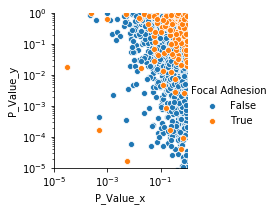

In [15]:
g = sns.FacetGrid(c_path, hue='Focal Adhesion')# col and row of the multiple grids , hue = pathway
g.map(sns.scatterplot, "P_Value_x", "P_Value_y").set(
    xscale = 'log').set(yscale = 'log')
g.map(sns.scatterplot, "P_Value_x", "P_Value_y").set(
    xscale = 'log').set(yscale = 'log')
plt.xlim(1e-5, 1e0) # 0.00005 to 1
plt.ylim(1e-5, 1e0)
g.add_legend()


In [13]:
f = pathways[['Gene','Focal Adhesion-PI3K-Akt-mTOR-signaling pathway','PDGF Pathway',
              'NRF2-ARE regulation','Vitamin D Receptor Pathway', 'Serotonin Transporter Activity']]
f

,Gene,Focal Adhesion-PI3K-Akt-mTOR-signaling pathway,PDGF Pathway,NRF2-ARE regulation,Vitamin D Receptor Pathway,Serotonin Transporter Activity
0,BAIAP2,False,False,False,False,False
1,CD4,False,False,False,False,False
2,GADS,False,False,False,False,False
3,FMR1,False,False,False,False,False
4,CCDC36,False,False,False,False,False
...,...,...,...,...,...,...
6157,ARR3,False,False,False,False,False
6158,GUCY1B2,False,False,False,False,False
6159,MAPK6,False,False,False,False,False
6160,CHST5,False,False,False,False,False


In [24]:
'''
@Param df1:
     Dataframe of p-values for the first cancer (x-axis). 
     The first column must include the trans gene name. 
@Param df1_name:
    String. Name of the x-axis. Include the first cancer name. 

@Param df2:
    Dataframe of p-values for the second cancer (y-axis).
    The first column must include the trans gene name. 
    
@Param df2_name:
    String. Name of the y-axis. Include the second cancer name.

@Param cat_df:
    Dataframe of Booleans. First column must be gene names. Can include
    up to 5 additional columns. Each column represents different
    groups specified with boolean variables (True is in the group). Each
    group will become a subplot graphing the p-values of the genes in that group.

This function creates a plot or multiple plots. The wrap_ttest function 
will help with creating df1 and df2. Both dataframes must have the gene 
included in the first column (omics can be included) and the p-value.
Wrap_ttest creates this needed dataframe when its parameter
return_all = True. 
'''

def binary_pval_plot(df1, df1_name, df2, df2_name, cat_df):
    # Step 1: Combine Dataframes
    combined = df1.merge(df2, on=df1.columns[0]) # merge 2 pval df
    combined = combined.replace(regex=True,to_replace='_proteomics', value='') # only gene names
    combined_df = combined.merge(cat_df, left_on= combined.columns[0], right_on= cat_df.columns[0]) # merge pathways
    combined_df = combined_df.rename(columns={combined_df.columns[1]: df1_name+" p-values", 
                                              combined_df.columns[2]: df2_name+" p-values"}) # Rename for x and y-axis
    
    # Step 2: Find dimensions of subplots
    paths = list(cat_df.columns[1:])
    total = len(paths) + 1
    #check_even = total % 2 #better way?
    if total <= 4:
        m_row = 2
        m_col = 2 
    elif total >= 5:
        m_row = 2
        m_col = 3
        
    plt.rcParams['figure.figsize']=(11.7,8.27) #size of plot
    sns.set(font_scale = 1)
    fig, axes = plt.subplots(m_row, m_col, sharex=True, sharey=True) # share x -axis title
    
    #Step 3: Create Subplots
    # First subplot with all p-values
    ax = sns.scatterplot(x=combined_df.columns[1], y=combined_df.columns[2], data=combined_df,  
        ax=axes[0, 0])
    ax.set_title("Comprehensive "+df1_name+" and "+df2_name+ " P-Values")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlim(1e-5, 1e0) # 0.00005 to 1
    plt.ylim(1e-5, 1e0)

    
    # Add plot for each pathway/group included in cat_df
    i = 0
    j = 1
    for e in paths:
        only_p = combined_df.loc[combined_df[e] == True]
        ax = sns.scatterplot(x=combined_df.columns[1], y=combined_df.columns[2], data=only_p, color='orange',
            ax=axes[i, j]).set_title(e)
        # i and j used to set next plot in ax
        if i <= (m_row - 1) and j < (m_col - 1):
            j += 1
        elif j == (m_col - 1):
            i+=1
            j=0
    
    plt.show()
    plt.clf()        
    plt.close()
    return ax


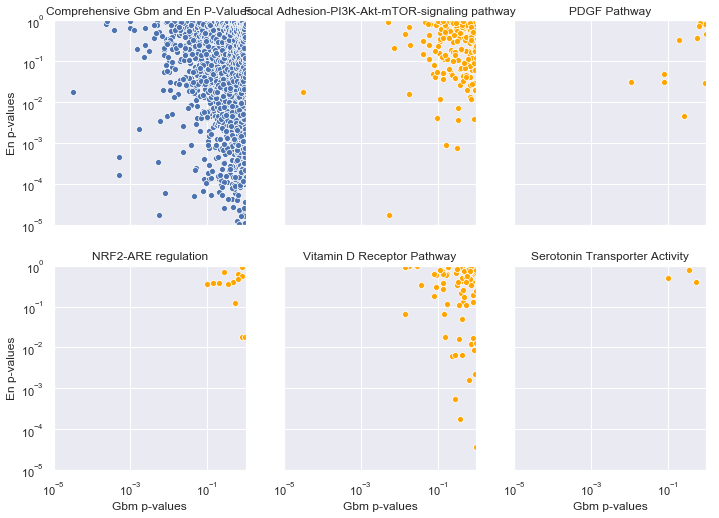

In [25]:
p = binary_pval_plot(wrap_results, "Gbm", wrap_results2, "En", f)


In [ ]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=both_values_df,
                   scatter_kws={'facecolors':both_values_df['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom x-axis (low endometrial p-values)

In [ ]:
low_endo_pvals = both_values_df.loc[both_values_df['P_Value_y'] <= 0.05] #graph
low_endo_pvals = low_endo_pvals.loc[low_endo_pvals['P_Value_x'] >= 0.5]

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_endo_pvals, 
                   scatter_kws={'facecolors':low_endo_pvals['color']})
plot.set_title("Low P_Value Distribution in Endometrial Only")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom y-axis (low gbm p-values)

In [ ]:
low_gbm_pvals = both_values_df.loc[both_values_df['P_Value_x'] <= 0.05]
low_gbm_pvals = low_gbm_pvals.loc[low_gbm_pvals['P_Value_y'] >= 0.5] #comment out to see all y

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_gbm_pvals, scatter_kws={'facecolors':low_gbm_pvals['color']})
plot.set_title("Low P_Value Distribution for Gbm Only")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

# GSEA 

In [ ]:
# corners for gsea test for zoomed x-axis (0-1 range gbm pvals)
low = combined.loc[combined['P_Value_y'] <= 0.05]
low_left_corner = low.loc[low['P_Value_x'] <= 0.05] 
low_right_corner = low.loc[low['P_Value_x'] >= 0.5] 

print("Number of both low:", len(low_left_corner))
print("Number of low endo, high gbm:", len(low_right_corner))

# corners for gsea test for zoomed y-axis (0-1 range endo pvals)
high = combined.loc[combined['P_Value_y'] >= 0.5] 
high_left_corner = high.loc[high['P_Value_x'] <= 0.05] 
high_right_corner = high.loc[high['P_Value_x'] >= 0.5]  
print("Number of high endo, low gbm:", len(high_left_corner))
print("Number of both high:", len(high_right_corner))

In [ ]:
# gsea for lower left corner (both low pvals)
both_low_pvals = list(low_left_corner['Comparison'])
print("Number of genes for both low pvals:", len(both_low_pvals))

both_low_gsea = gp.enrichr(
    gene_list = both_low_pvals, description='Tumor_partition', gene_sets='KEGG_2016')

In [ ]:
both_low_gsea.res2d.head() # pip2 signaling? check phosphatidylinositol proteins!

In [ ]:
# gsea for low right corner (low endo, high gbm)
low_endo_high_gbm = list(low_right_corner['Comparison'])
print("Number of genes for low_endo_high_gbm:", len(low_endo_high_gbm))

low_endo_high_gbm_gsea = gp.enrichr(
    gene_list = low_endo_high_gbm, description='Tumor_partition', gene_sets='KEGG_2016')

In [ ]:
g = low_endo_high_gbm_gsea.res2d.head()
#list(g['Genes'])
g

Range 0-1 endo (upper corners)

In [ ]:
# gsea for high left corner (high endo, low gbm)
high_endo_low_gbm = list(high_left_corner['Comparison'])
print("Number of genes for high_endo_low_gbm:", len(high_endo_low_gbm))

high_endo_low_gbm_gsea = gp.enrichr(
    gene_list = high_endo_low_gbm, gene_sets='KEGG_2016')


In [ ]:
gbm = high_endo_low_gbm_gsea.res2d.head() # check focal adhesions, endocytosis pathways
gbm

In [ ]:
# gsea for high right corner (high endo, high gbm)
both_high = list(high_right_corner['Comparison'])
print("Number of genes for both_high:", len(both_high))

both_high_gsea = gp.enrichr(
    gene_list = both_high, description='Tumor_partition', gene_sets='KEGG_2016')

In [ ]:
both_high_gsea.res2d.head()

Pathways

In [ ]:
focal_adhesions_str = "ACTN1;BCL2;RAPGEF1;FLNA;FLNC;MYL9;IGF1R"
focal_adhesions = focal_adhesions_str.split(';')

combined["color"] = np.where(combined["Comparison"].isin(focal_adhesions), "purple", "lightblue")
print(focal_adhesions)
pathway_df = combined.dropna(axis=0, how='any') # only keep rows with both data points
pathway_df

In [ ]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=pathway_df, 
                   scatter_kws={'facecolors':pathway_df['color']})
plot.set_title("P_Value Distribution showing Pathway")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()